In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

animes_data_path = "./preprocessed_data/preprocessed_animes.csv"
profiles_data_path = "./preprocessed_data/preprocessed_profiles.csv"
reviews_data_path = "./preprocessed_data/preprocessed_reviews.csv"

In [ ]:
animes_data = pd.read_csv(animes_data_path)
profiles_data = pd.read_csv(profiles_data_path)
reviews_data = pd.read_csv(reviews_data_path, engine='python', sep=',', error_bad_lines=False)

<ipython-input-2-28a1db8bd131>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  reviews_data = pd.read_csv("preprocessed_reviews.csv", engine='python', sep=',', error_bad_lines=False)


In [ ]:
animes = animes_data.copy()
profiles = profiles_data.copy()
reviews = reviews_data.copy()

## **Train-Test Split (0.7 - 0.3)**

In [ ]:
from scipy.sparse import coo_matrix
import torch
import torch.nn as nn
import numpy as np

np.random.seed(0)
unique_AnimeID = reviews['anime_uid'].unique()
unique_users = reviews['profile'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_users:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
for i in unique_AnimeID:
    movie_old2new_id_dict[i] = j
    j += 1
    
# Then, use the generated dictionaries to reindex UserID and MovieID in the data_df
user_list = reviews['profile'].values
movie_list = reviews['anime_uid'].values
for j in range(len(reviews)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    movie_list[j] = movie_old2new_id_dict[movie_list[j]]
reviews['profile'] = user_list
reviews['anime_uid'] = movie_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
train_index = np.random.random(len(reviews)) <= 0.7
train_df = reviews[train_index]
test_df = reviews[~train_index]

# generate train_mat and test_mat
num_user = len(reviews['profile'].unique())
num_items = len(reviews['anime_uid'].unique())

train_mat = coo_matrix((train_df['score'].values, (train_df['profile'].values, train_df['anime_uid'].values)), shape=(num_user, num_items)).astype(float).toarray()
test_mat = coo_matrix((test_df['score'].values, (test_df['profile'].values, test_df['anime_uid'].values)), shape=(num_user, num_items)).astype(float).toarray()
train_data = torch.FloatTensor(train_mat)
test_data = torch.FloatTensor(test_mat)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
batchSize = 512
train_loader = DataLoader(TensorDataset(train_data), batch_size=batchSize, shuffle=False)
test_loader = DataLoader(TensorDataset(test_data), batch_size=batchSize, shuffle=False)

## **Define Autoencoder model**

In [ ]:
# Load rating matrix
encoding_dim = 100
rating_scale = 10
num_items = len(animes)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_items, encoding_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, encoding_dim//2),
            nn.ReLU())
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim//2, encoding_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, num_items),
            nn.Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        # Sigmoid outputs 0 - 1 -> we need to scale to 1 - 10
        decoded = rating_scale * self.decoder(encoded)
        return decoded

## **Train and Evaluate model**

In [ ]:
epochs = 50

autoencoder_model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(autoencoder_model.parameters(), lr=0.0001)
train_loss = []
test_loss = []
for epoch in range(epochs):
    autoencoder_model.train()
    running_train_loss = []
    for data in train_loader:
      optimizer.zero_grad()
      decoded = autoencoder_model(data[0])
      decoded[data[0] == 0] = 0
      loss = criterion(decoded, data[0]) * torch.numel(data[0]) / torch.count_nonzero(data[0])
      running_train_loss.append(np.sqrt(loss.item()))
      loss.backward()
      optimizer.step()
    
    autoencoder_model.eval()
    running_test_loss = []
    '''
    with torch.no_grad():
        for data in test_loader:
            decoded = autoencoder_model(data[0])
            decoded[data[0] == 0] = 0
            running_test_loss.append(np.sqrt(criterion(decoded, data[0]))) '''
            
    with torch.no_grad():
      for data_tr, data_te in zip(train_loader, test_loader):
        decoded = autoencoder_model(data_tr[0])
        decoded[data_te[0] == 0] = 0
        loss = criterion(data_te[0], decoded) * torch.numel(data_te[0]) / torch.count_nonzero(data_te[0])
        running_test_loss.append(np.sqrt(loss.detach().numpy()))
    
    print('Epoch', epoch + 1, 'of', epochs, end=': ')
    print('RMSE Train Loss: {:.4f}'.format(np.mean(running_train_loss)), end=', ')
    print('RMSE Test Loss: {:.4f}'.format(np.mean(running_test_loss)))

    train_loss.append(np.mean(running_train_loss))
    test_loss.append(np.mean(running_test_loss))

Epoch 1 of 50: RMSE Train Loss: 3.1686, RMSE Test Loss: 3.1681
Epoch 2 of 50: RMSE Train Loss: 3.0864, RMSE Test Loss: 3.0870
Epoch 3 of 50: RMSE Train Loss: 2.9272, RMSE Test Loss: 2.9430
Epoch 4 of 50: RMSE Train Loss: 2.7204, RMSE Test Loss: 2.7974
Epoch 5 of 50: RMSE Train Loss: 2.5420, RMSE Test Loss: 2.6886
Epoch 6 of 50: RMSE Train Loss: 2.4136, RMSE Test Loss: 2.6102
Epoch 7 of 50: RMSE Train Loss: 2.3212, RMSE Test Loss: 2.5551
Epoch 8 of 50: RMSE Train Loss: 2.2521, RMSE Test Loss: 2.5106
Epoch 9 of 50: RMSE Train Loss: 2.1961, RMSE Test Loss: 2.4770
Epoch 10 of 50: RMSE Train Loss: 2.1503, RMSE Test Loss: 2.4470
Epoch 11 of 50: RMSE Train Loss: 2.1102, RMSE Test Loss: 2.4229
Epoch 12 of 50: RMSE Train Loss: 2.0745, RMSE Test Loss: 2.3996
Epoch 13 of 50: RMSE Train Loss: 2.0413, RMSE Test Loss: 2.3790
Epoch 14 of 50: RMSE Train Loss: 2.0102, RMSE Test Loss: 2.3578
Epoch 15 of 50: RMSE Train Loss: 1.9802, RMSE Test Loss: 2.3391
Epoch 16 of 50: RMSE Train Loss: 1.9519, RMSE Tes

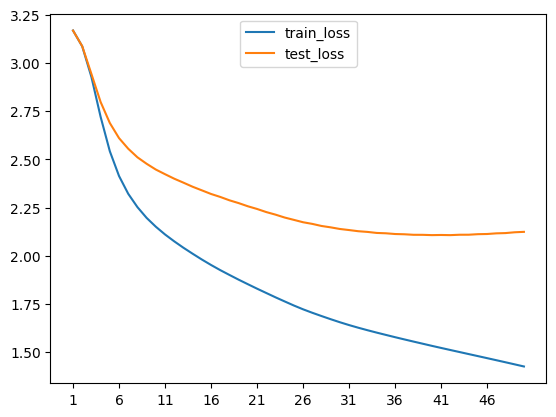

In [54]:
import matplotlib.pyplot as plt
x = [i + 1 for i in range(epochs)]
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, test_loss, label='test_loss')
leg = plt.legend(loc='upper center')
plt.xticks([i + 1 for i in range(0, epochs, 5)]) 
plt.show()